In [46]:
import pandas as pd
import matplotlib as plt
import numpy as np
import seaborn as sns  # seaborn画出的图更好看，且代码更简单，缺点是可塑性差
from statsmodels.graphics.tsaplots import plot_acf  # 自相关图
from statsmodels.tsa.stattools import adfuller as ADF  # 平稳性检测
from statsmodels.graphics.tsaplots import plot_pacf  # 偏自相关图
from statsmodels.stats.diagnostic import acorr_ljungbox  # 白噪声检验
from statsmodels.tsa.arima_model import ARIMA
import statsmodels
import datetime
%matplotlib inline

%pylab inline

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.rcParams['figure.figsize'] = (20, 10)  # 设置输出图片大小
sns.set(color_codes=True)  # seaborn设置背景
#读数据
bt = pd.read_csv('org_data/BCHAIN-MKPRU.csv')
gold = pd.read_csv('org_data/LBMA-GOLD.csv')
#日期转换
bt.Date=pd.to_datetime(bt.Date)
gold.Date=pd.to_datetime(gold.Date).dt.normalize()
# 合并
df = gold.merge(bt, on='Date',how='outer')
#时间排序
df=df.sort_values(by='Date')
#重设索引
df.index=[i for i in range(df.shape[0])]
# 是否是交易日
df['DealDay']=df['USD (PM)'].apply(lambda x:int(not np.isnan(x)))
# 填充空值（前一个非空值）
df=df.fillna(method='ffill')

df.to_excel('table/黄金-比特币-黄金交易日表.xlsx')

Populating the interactive namespace from numpy and matplotlib


D:\python\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [47]:
df['黄金涨幅'] = 0
df['比特币涨幅'] = 0
for i in df.index[1:]:
    df['黄金涨幅'][i] = (df['USD (PM)'][i]-df['USD (PM)'][i-1])
    df['比特币涨幅'][i] = (df['Value'][i]-df['Value'][i-1])
df


<ipython-input-47-e8458e7267f9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['黄金涨幅'][i] = (df['USD (PM)'][i]-df['USD (PM)'][i-1])
D:\python\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-47-e8458e7267f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['比特币涨幅'][i] = (df['Value'][i]-df['Value'][i-1])


,Date,USD (PM),Value,DealDay,黄金涨幅,比特币涨幅
0,2016-09-11,NaN,621.65,0,0.00,0
1,2016-09-12,1324.60,609.67,1,NaN,-11
2,2016-09-13,1323.65,610.92,1,-0.95,1
3,2016-09-14,1321.75,608.82,1,-1.90,-2
4,2016-09-15,1310.80,610.38,1,-10.95,1
...,...,...,...,...,...,...
1821,2021-09-06,1821.60,51769.06,1,-2.10,1821
1822,2021-09-07,1802.15,52677.40,1,-19.45,908
1823,2021-09-08,1786.00,46809.17,1,-16.15,-5868
1824,2021-09-09,1788.25,46078.38,1,2.25,-730


注意更改N值选取

In [48]:
df['黄金12日均价'] = df['USD (PM)'].rolling(12).mean()
df['黄金12日乖离率'] = 100*(df['USD (PM)']-df['黄金12日均价'])/df['黄金12日均价']
df['比特币6日均价'] = df['Value'].rolling(6).mean()
df['比特币6日乖离率'] = 100*(df['Value']-df['比特币6日均价'])/df['比特币6日均价']
df.to_excel('table/乖离率-均价表.xlsx')


In [49]:

df['黄金投资风险']=0
df['比特币投资风险']=0
df['黄金持有份额']=0
df['比特币持有份额']=0
df['现金持有份额']=0
df['总资产']=0
df['预计黄金涨幅'] = 0
df['预计比特币涨幅'] = 0
df['预计现金持有份额'] = 0
df['预计总资产'] = 0
df['当前黄金利润'] = 0
df['当前比特币利润'] = 0

In [50]:
# 归一化
df=df.fillna(0)
for column in df.columns[3:10]:
    max_,min_=df[column].max(),df[column].min()
    df[column]=df[column].apply(lambda x:(x-min_)/(max_-min_))
df.to_excel('table/归一化.xlsx')
df.head()

,Date,USD (PM),Value,DealDay,黄金涨幅,比特币涨幅,黄金12日均价,黄金12日乖离率,比特币6日均价,比特币6日乖离率,...,黄金持有份额,比特币持有份额,现金持有份额,总资产,预计黄金涨幅,预计比特币涨幅,预计现金持有份额,预计总资产,当前黄金利润,当前比特币利润
0,2016-09-11,0.00,621.65,0.0,0.566145,0.510080,0.0,0.555288,0.0,0.537543,...,0,0,0,0,0,0,0,0,0,0
1,2016-09-12,1324.60,609.67,1.0,0.566145,0.509356,0.0,0.555288,0.0,0.537543,...,0,0,0,0,0,0,0,0,0,0
2,2016-09-13,1323.65,610.92,1.0,0.561015,0.510146,0.0,0.555288,0.0,0.537543,...,0,0,0,0,0,0,0,0,0,0
3,2016-09-14,1321.75,608.82,1.0,0.555886,0.509949,0.0,0.555288,0.0,0.537543,...,0,0,0,0,0,0,0,0,0,0
4,2016-09-15,1310.80,610.38,1.0,0.507019,0.510146,0.0,0.555288,0.0,0.537543,...,0,0,0,0,0,0,0,0,0,0


D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29275 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29066 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29275 missing from current font.
  font.set_text(s, 0, flags=flags)


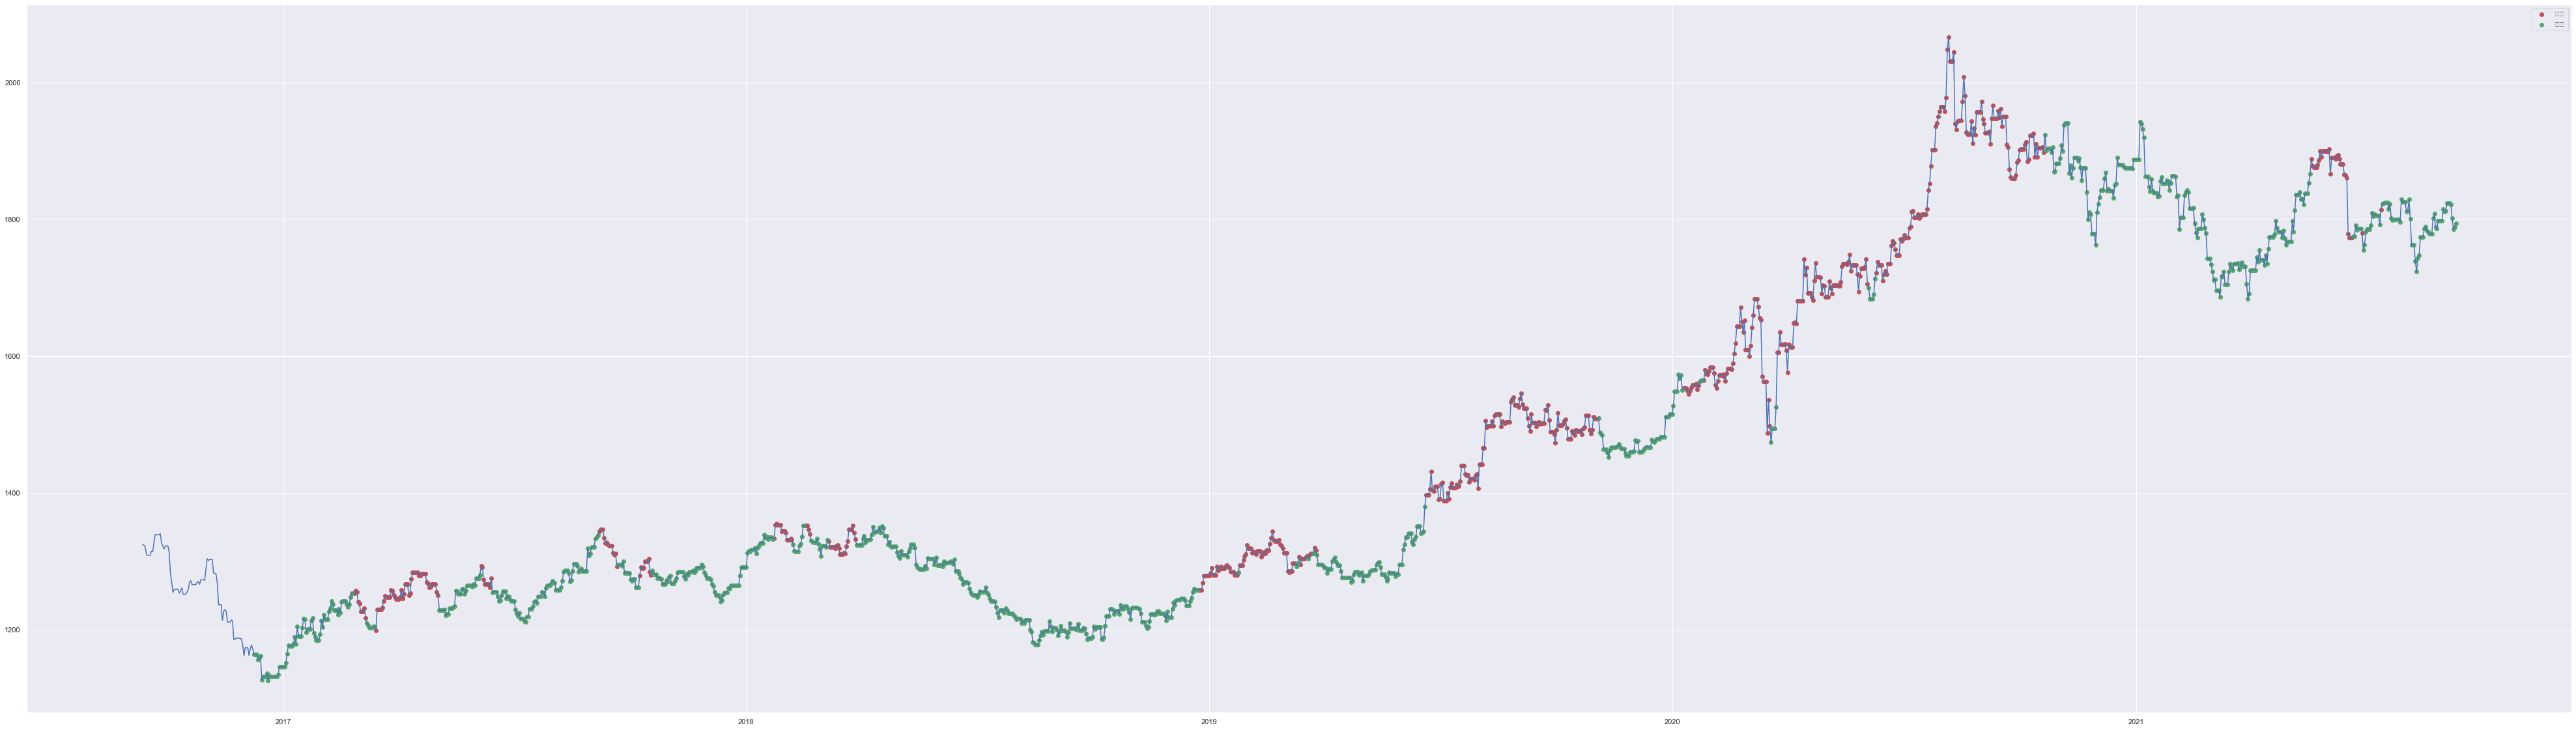

In [51]:
df['黄金牛市'] = df['黄金涨幅'].rolling(90).mean(
)*0.666+0.333*df['黄金12日乖离率'].rolling(90).mean()
gold_cow = []
gold_bear = []
for i in range(15, df.shape[0]):
    if df['黄金牛市'][i] > 0.57:
        gold_cow.append(i)
    if df['黄金牛市'][i] <= 0.57:
        gold_bear.append(i)
plt.plot(df['Date'][1:], df['USD (PM)'][1:])
plt.scatter(df['Date'][gold_cow].values, df['USD (PM)']
            [gold_cow], c='r', label='熊市')
plt.scatter(df['Date'][gold_bear].values, df['USD (PM)']
            [gold_bear], c='g', label='牛市')
plt.legend()
plt.savefig('img/黄金牛市分布图.png')
plt.show()



<ipython-input-52-41453dcd08ee>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gold_cow'][j] += 1
<ipython-input-52-41453dcd08ee>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['gold_cow'][j] -= 1
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29275 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29066 m

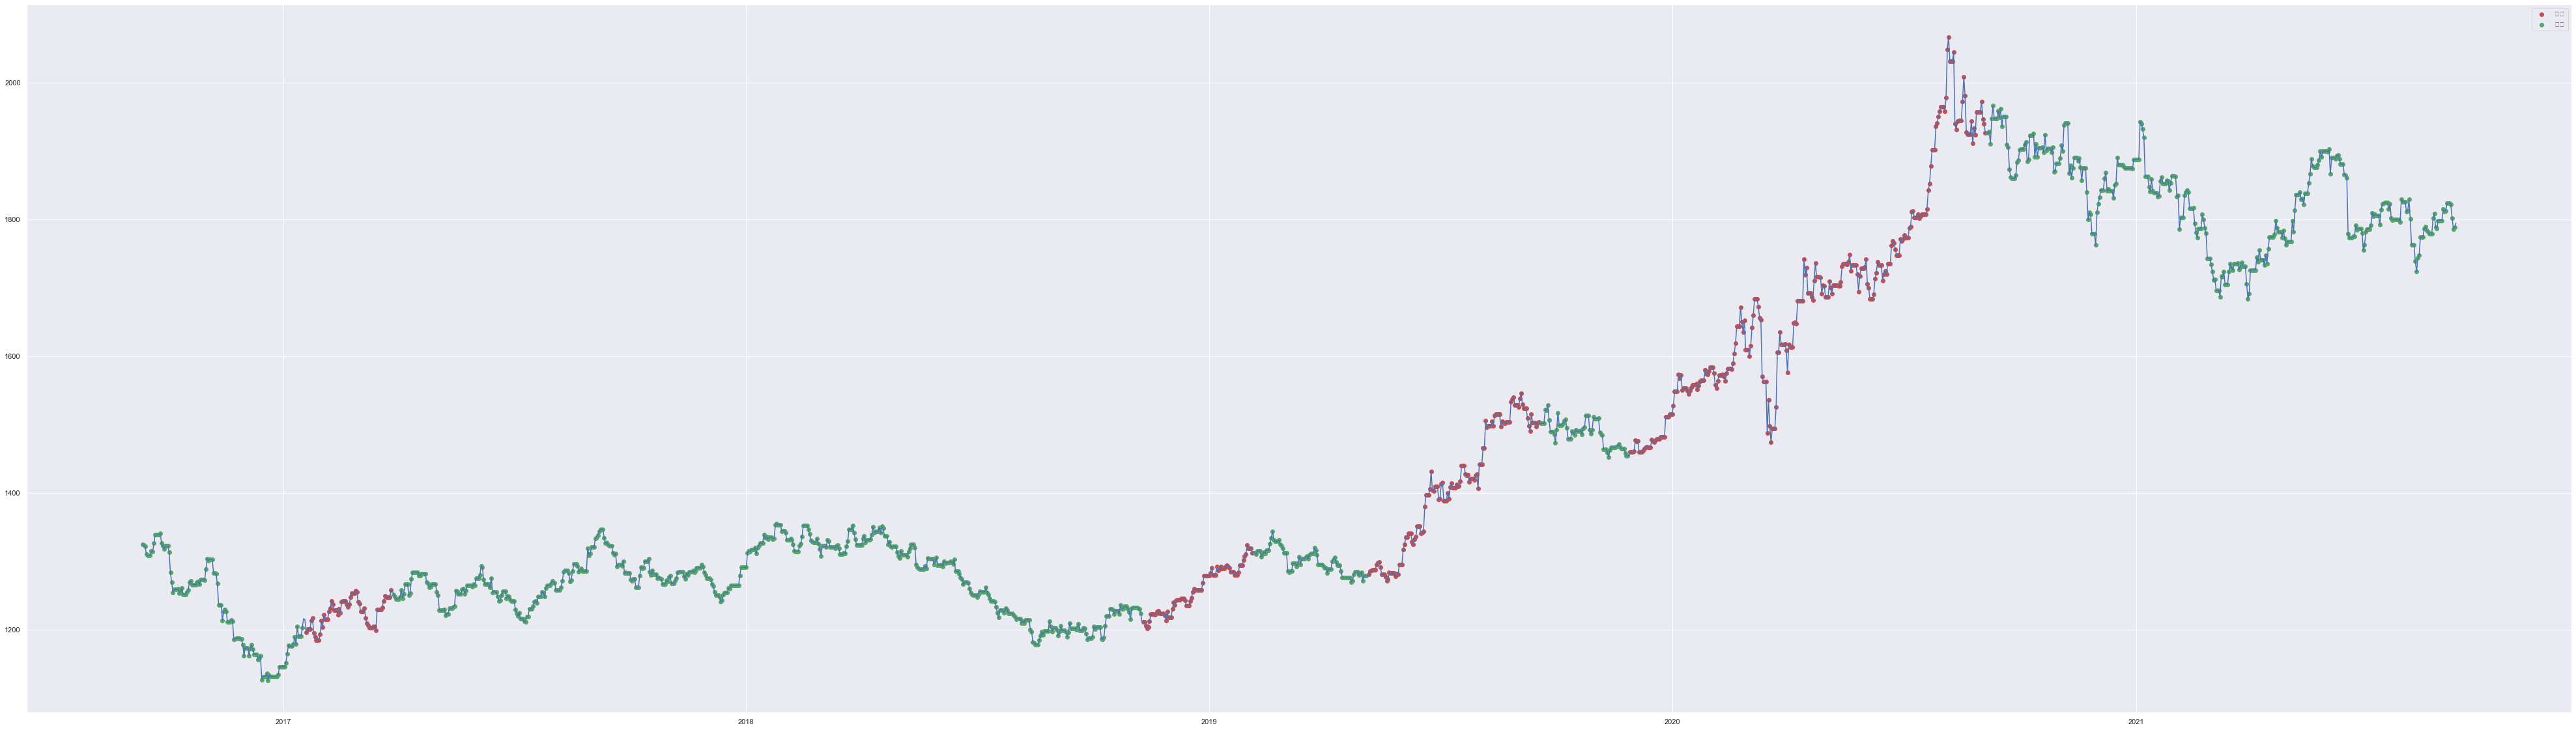

In [52]:
df['gold_cow'] = 0
for i in gold_cow:
    if i < 90:
        continue
    for j in range(i-90, i):
        df['gold_cow'][j] += 1
for i in gold_bear:
    if i < 90:
        continue
    for j in range(i-90, i):
        df['gold_cow'][j] -= 1
# 数据的第一天不是黄金交易日，且没有数据可以补充，所以直接从第二天开始
plt.plot(df['Date'][1:], df['USD (PM)'][1:])
plt.scatter(df['Date'][df['gold_cow'] > 0][1:], df['USD (PM)']
            [df['gold_cow'] > 0][1:], c='r', label='牛市')
plt.scatter(df['Date'][df['gold_cow'] < 0][1:], df['USD (PM)']
            [df['gold_cow'] < 0][1:], c='g', label='熊市')
plt.legend()
plt.savefig('img/黄金牛市最终分布图.png')
plt.show()


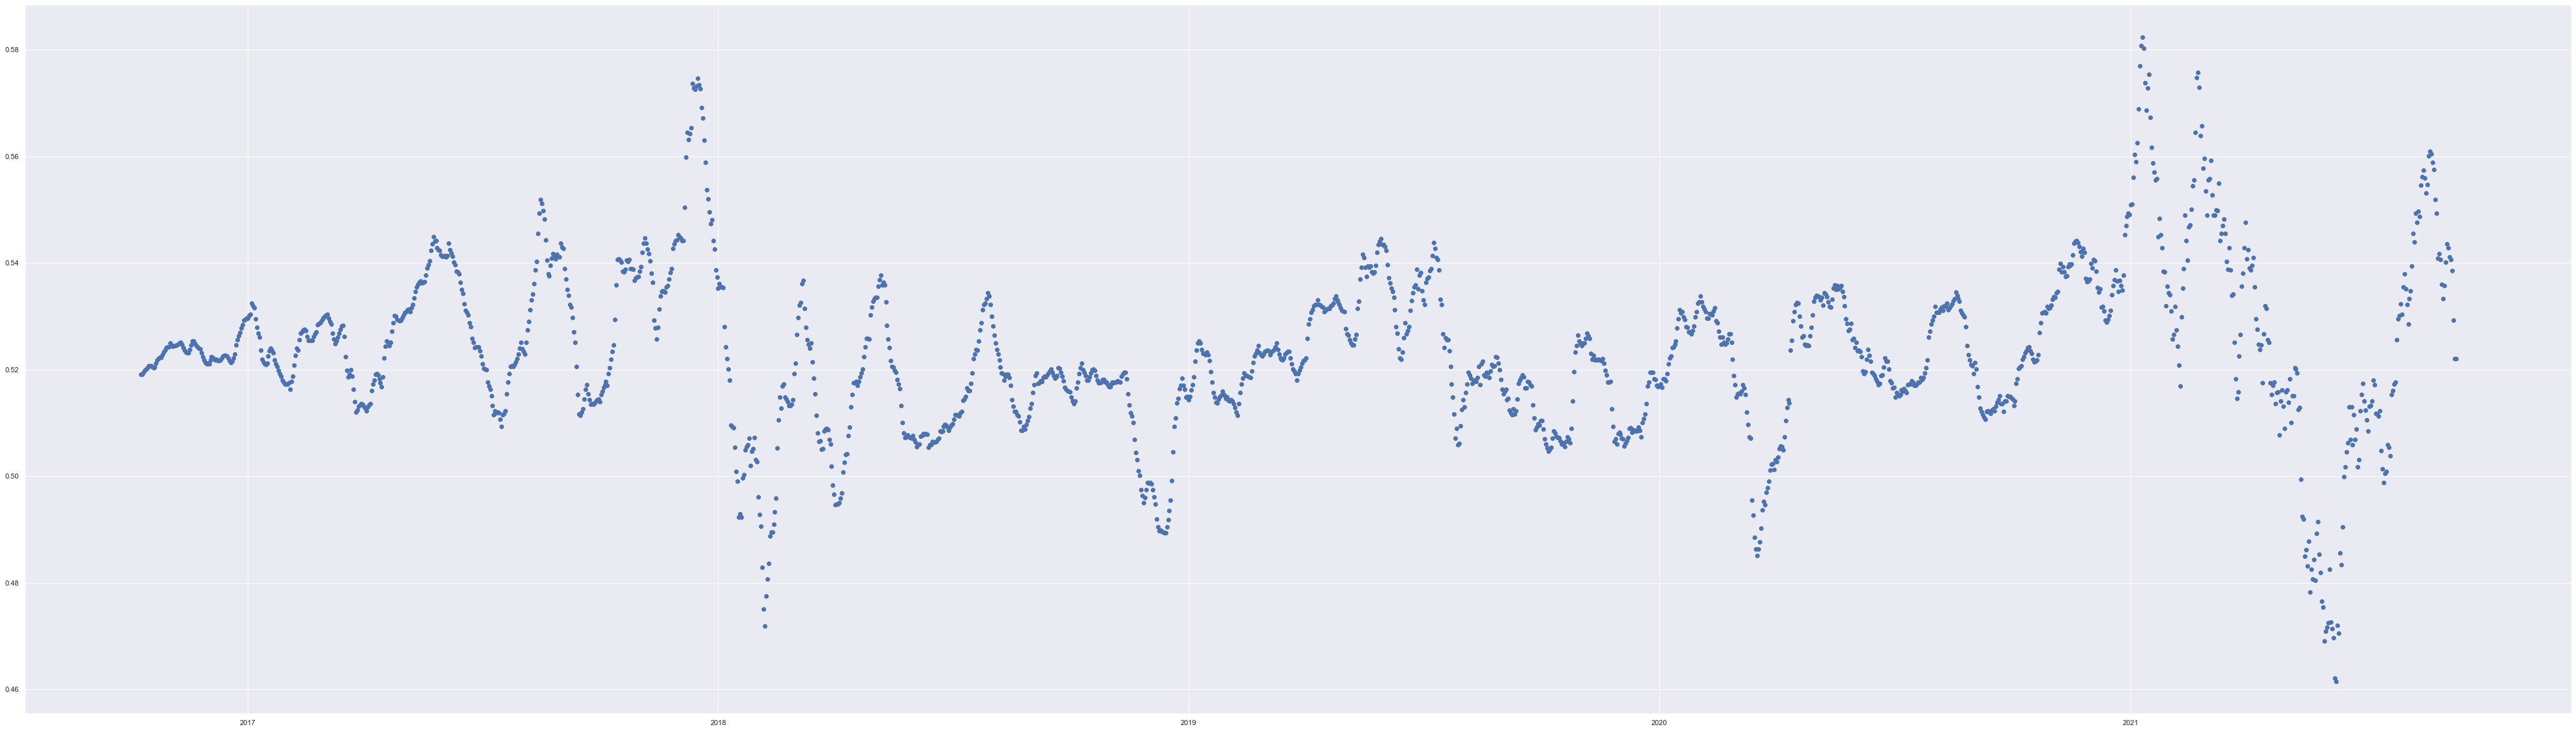

In [53]:
df['比特币牛市'] = df['比特币涨幅'].rolling(30).mean(
)*0.666+0.333*df['比特币6日乖离率'].rolling(30).mean()
plt.scatter(df['Date'], df['比特币牛市'])
plt.savefig('img/比特币牛市指标图.png')
plt.show()
bt_cow = []
bt_bear = []
for i in range(15, df.shape[0]):
    if df['比特币牛市'][i] > 0.52:
        bt_cow.append(i)
    if df['比特币牛市'][i] <= 0.52:
        bt_bear.append(i)


D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29275 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29275 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\python\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 29066 missing from current font.
  font.set_text(s, 0, flags=flags)


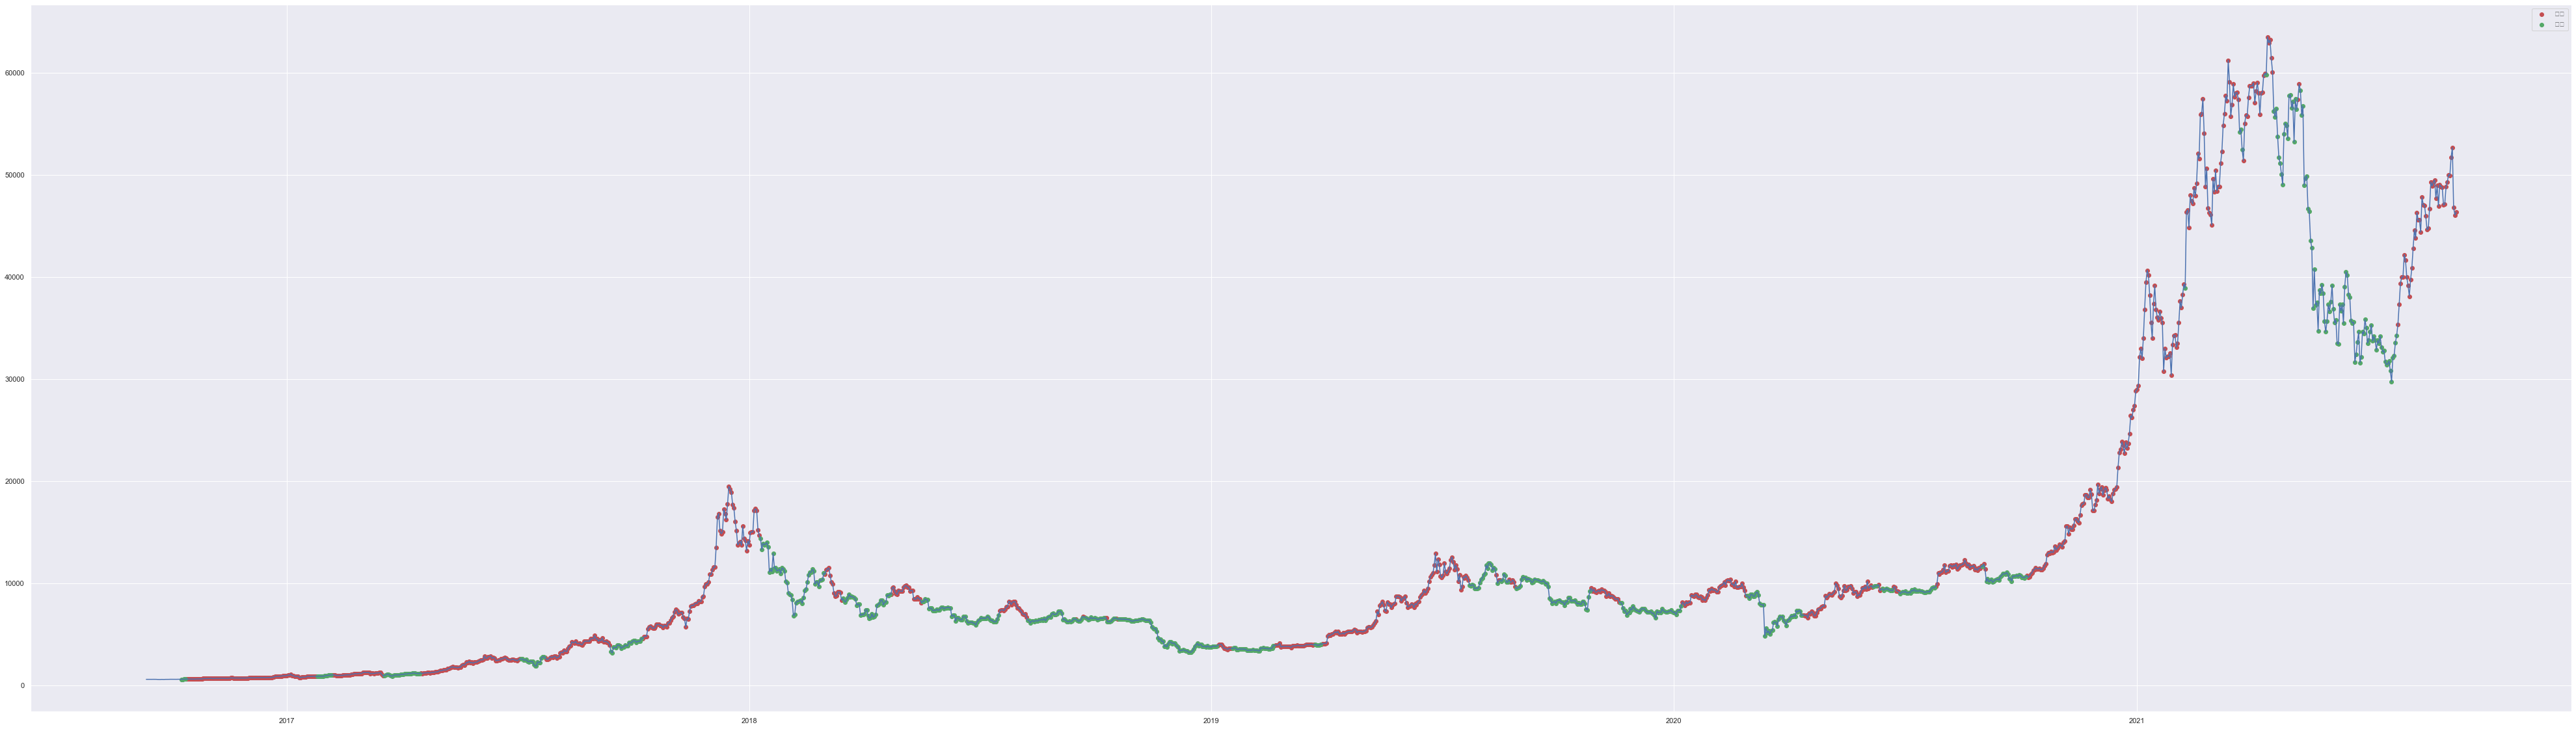

In [54]:
plt.plot(df['Date'][1:], df['Value'][1:])
plt.scatter(df['Date'][bt_cow].values, df['Value'][bt_cow], c='r', label='牛市')
plt.scatter(df['Date'][bt_bear].values, df['Value']
            [bt_bear], c='g', label='熊市')
plt.legend()
plt.savefig('img/比特币牛市分布图.png')
plt.show()


In [55]:
df['bt_cow'] = 0
for i in bt_cow:
    if i < 30:
        continue
    for j in range(i-30, i):
        df['bt_cow'][j] += 1
for i in bt_bear:
    if i < 30:
        continue
    for j in range(i-30, i):
        df['bt_cow'][j] -= 1


<ipython-input-55-3f8692f03693>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bt_cow'][j] += 1
<ipython-input-55-3f8692f03693>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bt_cow'][j] -= 1


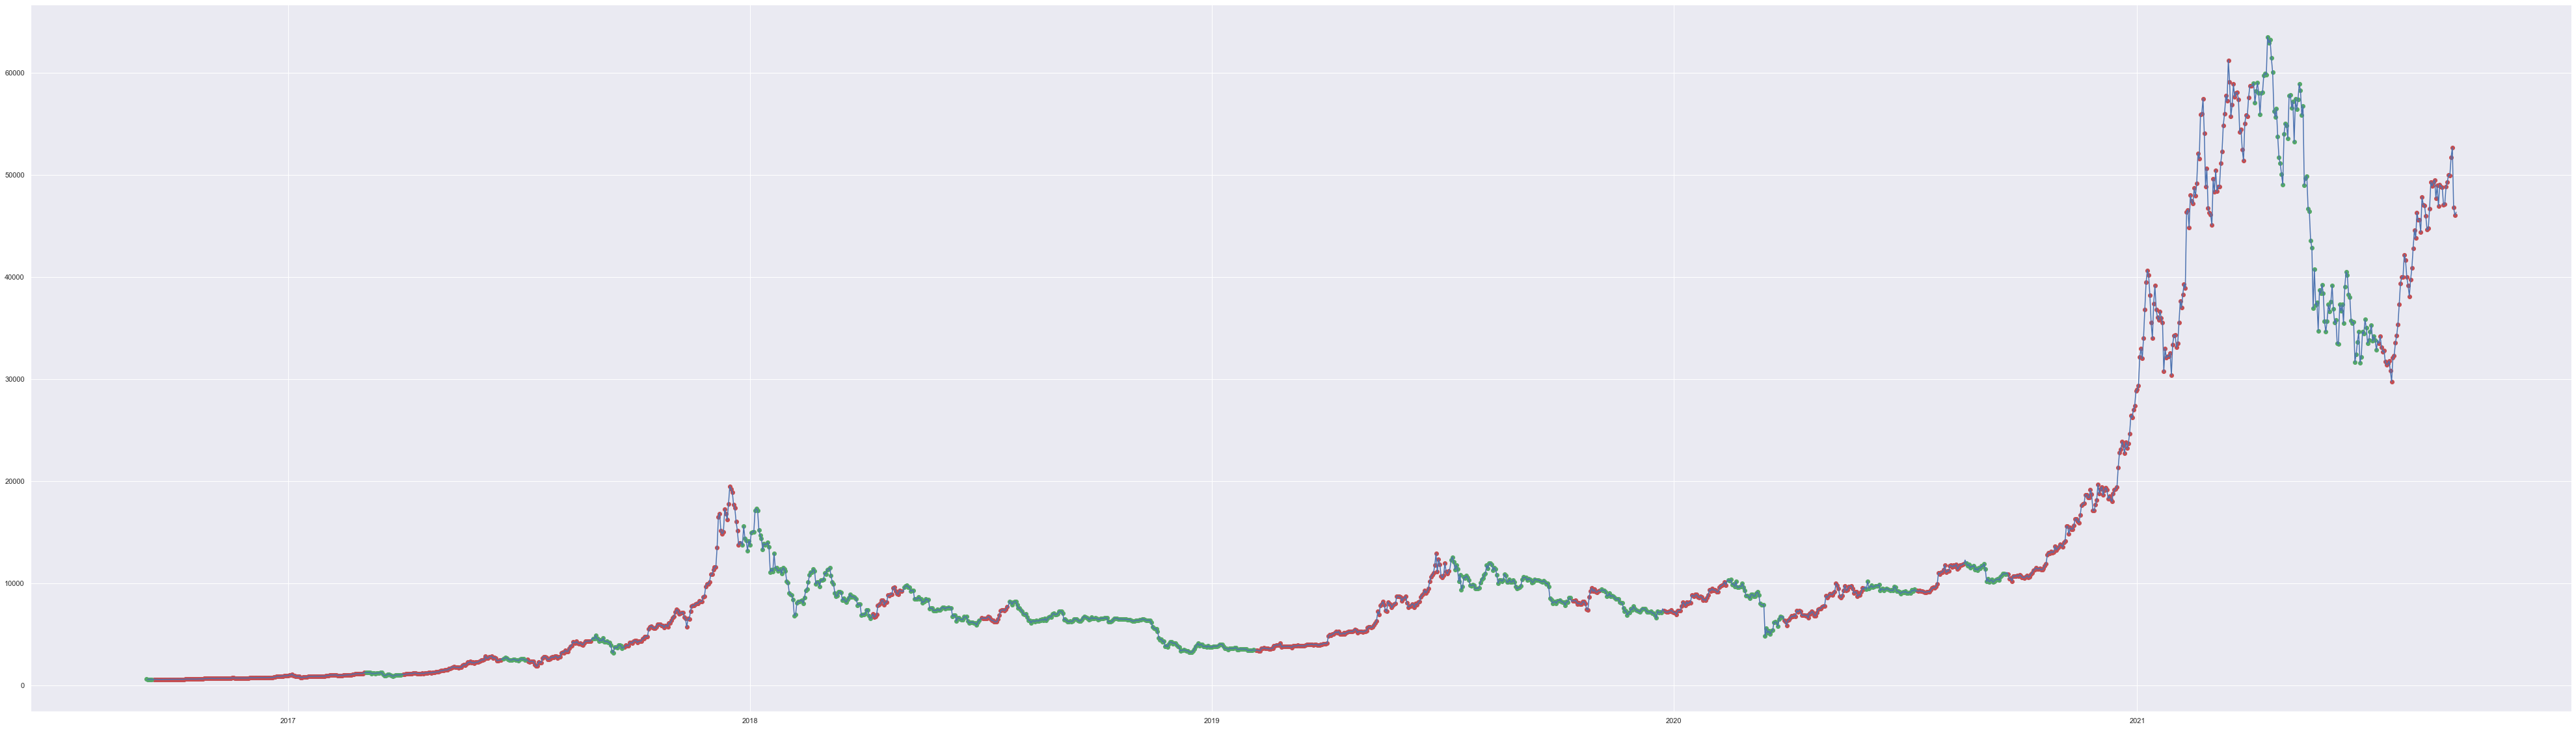

In [56]:
plt.plot(df['Date'][1:], df['Value'][1:])
plt.scatter(df['Date'][df['bt_cow'] > 0], df['Value'][df['bt_cow'] > 0], c='r')
plt.scatter(df['Date'][df['bt_cow'] < 0], df['Value'][df['bt_cow'] < 0], c='g')
plt.savefig('img/比特币牛市最终分布图.png')
plt.show()


In [57]:
max_, min_ = df['gold_cow'].max(), df['gold_cow'].min()
df['黄金牛市'] = df['gold_cow'].apply(lambda x: (x-min_)/(max_-min_))
max_, min_ = df['bt_cow'].max(), df['bt_cow'].min()
df['比特币牛市'] = df['bt_cow'].apply(lambda x: (x-min_)/(max_-min_))


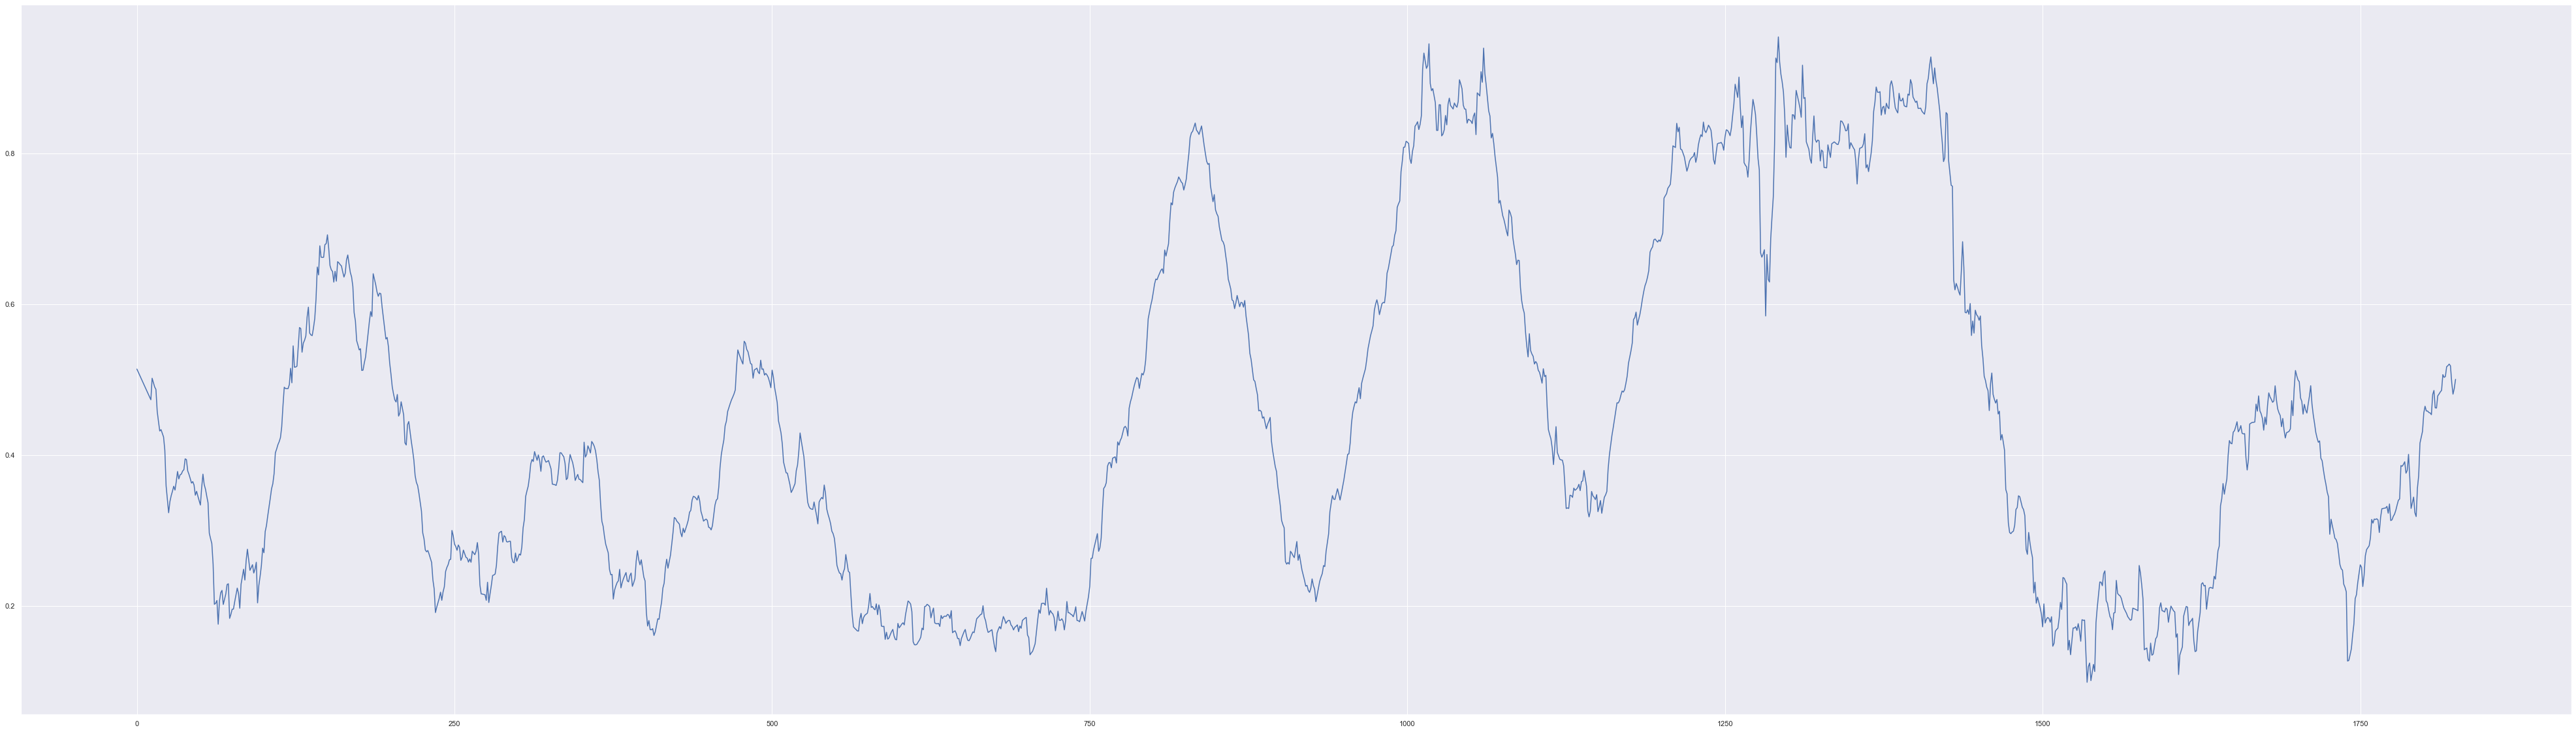

In [58]:
df['黄金购买风险'] = df['黄金牛市']*0.666+df['黄金12日乖离率']*0.333
plt.plot(df['黄金购买风险'])
plt.savefig('img/黄金购买风险图.png')
plt.show()


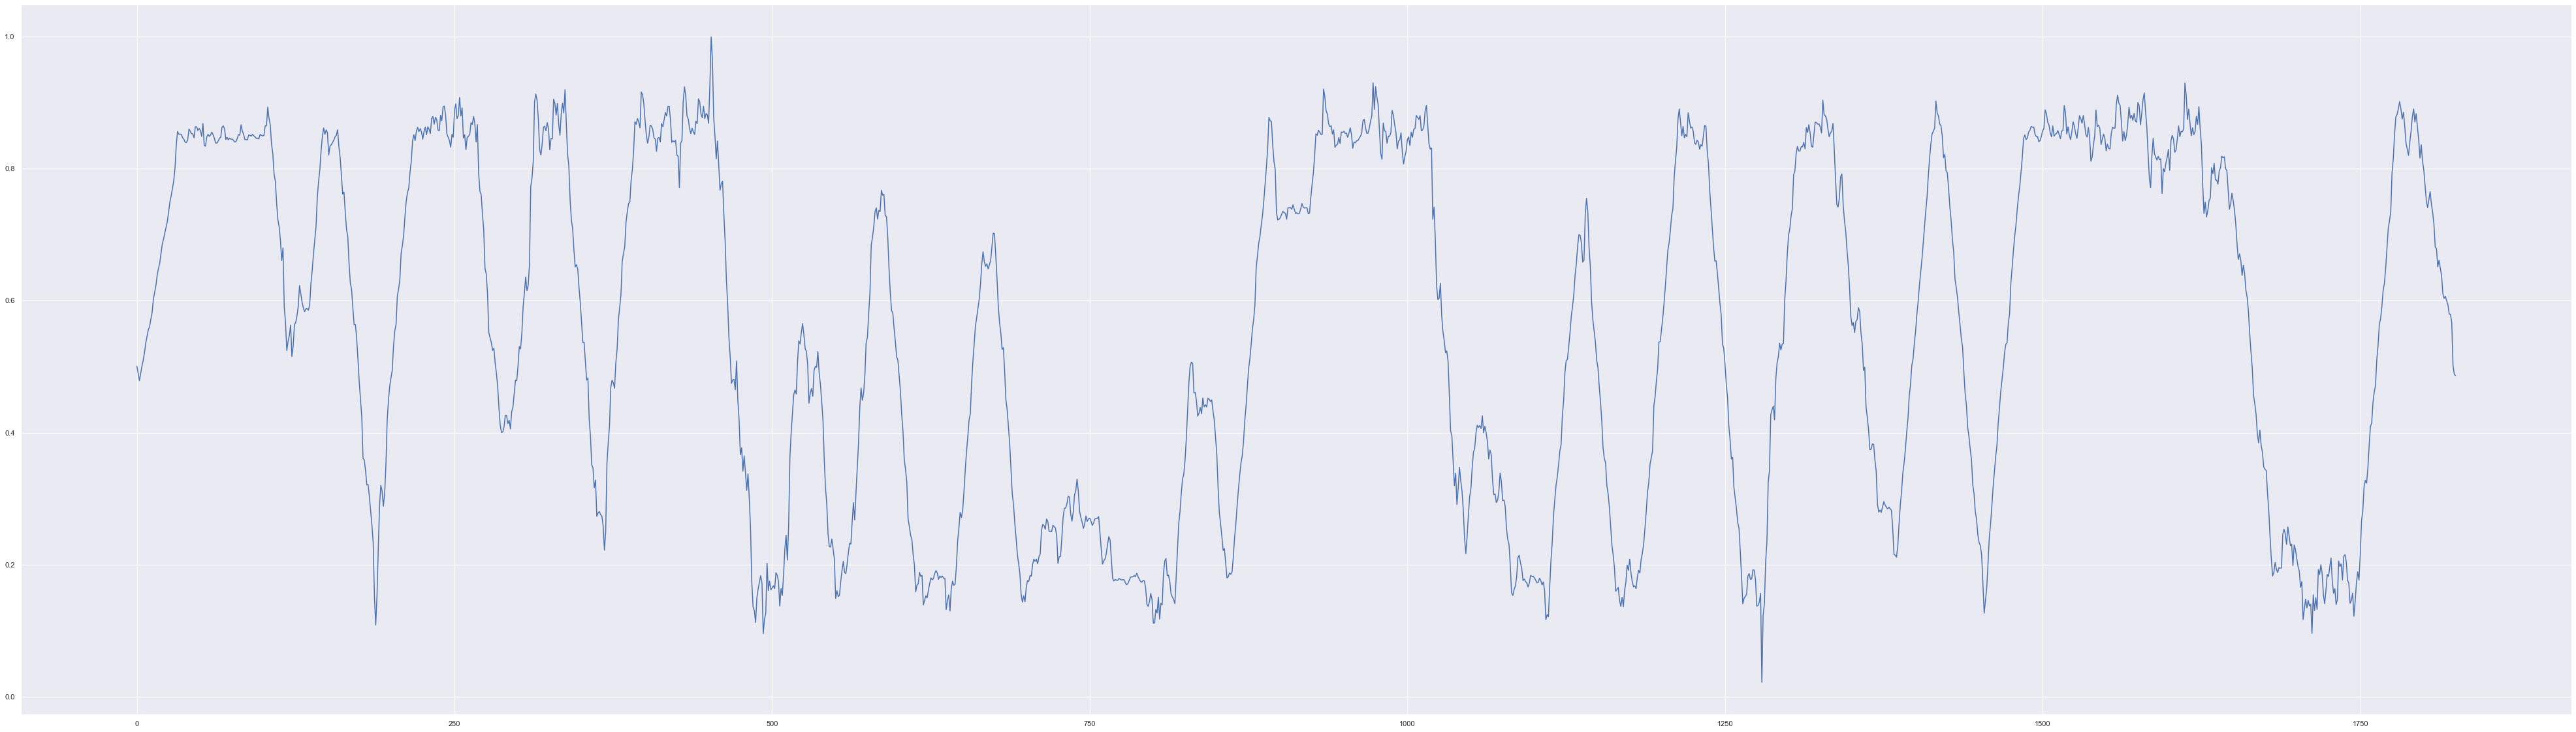

In [59]:
df['比特币购买风险']=df['比特币牛市']*0.666+df['比特币6日乖离率']*0.333
plt.plot(df['比特币购买风险'])
plt.savefig('img/比特币购买风险图.png')
plt.show()

In [60]:
df.to_excel('table/表.xlsx')
